In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Hyperparameter
batch_size = 20
z_dim = 128
learning_rate_gen = 2e-4
learning_rate_dis = 2e-4
max_step = 20000
n_dis = 5
# lambda (gradient panelty)
lam = 10.

from data_utils_batch import *
data_X = labelDataReader('../data/animate_label_twingan/')
batch_x, batch_y = data_X.next_batch(100)
f_dim = batch_y.shape[1]
print ('label dimension:', f_dim)
print ('data range:', np.max(batch_x), np.min(batch_x))

kernel_init = tf.random_normal_initializer(stddev = 0.02)

reload = True
reload_dir = '../model_2018_10_02/cgan-59600'
reload_epoch = 59600

label dimension: 51
data range: 0.32220891869149304 -0.7596269875073646


In [3]:
def residual_block(x, filters = 64):
    conv1 = tf.layers.conv2d(x, 
                             filters = filters,
                             kernel_size = 3,
                             strides = 1,
                             padding = 'same',
                             kernel_initializer = kernel_init)
    conv1 = tf.layers.batch_normalization(conv1)
    conv1 = tf.nn.relu(conv1)
    
    conv2 = tf.layers.conv2d(conv1,
                             filters = filters,
                             kernel_size = 3,
                             strides = 1,
                             padding = 'same',
                             kernel_initializer = kernel_init)
    conv2 = tf.layers.batch_normalization(conv2)
    
    return tf.add(x, conv2)

def pixel_shuffle(I, r):
    bsize, a, b, c = I.get_shape().as_list()
    X = tf.reshape(I, (-1, a, b, r, r))
    X = tf.split(X, a, 1)  # a, [bsize, b, r, r]
    X = tf.concat([tf.squeeze(x) for x in X], 2)  # bsize, b, a*r, r
    X = tf.split(X, b, 1)  # b, [bsize, a*r, r]
    X = tf.concat([tf.squeeze(x) for x in X], 2)  # bsize, a*r, b*r
    return tf.reshape(X, (-1, a*r, b*r, 1))

def PS(X, r):
    Xc = tf.split(X, X.get_shape()[3] // (r ** 2), 3)
    X = tf.concat([pixel_shuffle(x, r) for x in Xc], 3)
    return X

def resize_block(x, filters):
    out = tf.layers.conv2d(x,
                           filters = filters,
                           kernel_size = 3,
                           strides = 1,
                           padding = 'same',
                           kernel_initializer = kernel_init)
    out = PS(out, 2)
    out = tf.layers.batch_normalization(out)
    return tf.nn.relu(out)

In [4]:
# Define Generator Network
def generator(x, label, reuse = False):
    with tf.variable_scope('generator', reuse = reuse):
        data = tf.concat([x, label], axis = 1)
        fc1 = tf.layers.dense(data, 
                              units = 6 * 6 * 256, 
                              activation = tf.nn.leaky_relu,
                              kernel_initializer = kernel_init)
        fc1 = tf.layers.batch_normalization(fc1)
        fc1 = tf.reshape(fc1, [-1, 6, 6, 256])

        # First Convolutional Layer
        conv1 = tf.layers.conv2d_transpose(fc1, 
                                           filters = 128, 
                                           kernel_size = 5,
                                           strides = 2,
                                           padding = 'same',
                                           activation = tf.nn.leaky_relu,
                                           kernel_initializer = kernel_init)
        conv1 = tf.layers.batch_normalization(conv1)

        res_blocks = []
        res_blocks.append(conv1)
        for i in range(4):
            res_blocks.append(residual_block(res_blocks[i], filters = 128))
            
            
        resize1 = resize_block(res_blocks[-1], filters = 128)
        resize2 = resize_block(resize1, filters = 128)
        resize3 = resize_block(resize2, filters = 128)
        
        # Third Convolutional Layer (Output Layer with tanh activation)
        output = tf.layers.conv2d_transpose(resize3, 
                                            filters = 3, 
                                            kernel_size = 9, 
                                            strides = 1,
                                            padding = 'same',
                                            activation = tf.nn.tanh,
                                            kernel_initializer = kernel_init)
        return output

# test
# z_input = tf.placeholder(tf.float32, shape = [None, z_dim], name = 'gen_input')
# generator(z_input)

In [5]:
def discriminator(x, label, reuse = False):
    with tf.variable_scope('discriminator', reuse = reuse):
        
        # conv1: 48 * 48 * 64
        conv1 = tf.layers.conv2d(x,
                                 filters = 64,
                                 kernel_size = 5,
                                 strides = 2,
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        conv1 = tf.layers.batch_normalization(conv1)
        
        
        # conv2: 24 * 24 * 64
        conv2 = tf.layers.conv2d(conv1,
                                 filters = 64,
                                 kernel_size = 5,
                                 strides = 2,
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        conv2 = tf.layers.batch_normalization(conv2)
        
        # Residual Blocks
        res1 = residual_block(conv2, filters = 64)
        res2 = residual_block(res1, filters = 64)
        # res3 = residual_block(res2, filters = 64)
        
        # conv3: 12 * 12 * 64
        conv3 = tf.layers.conv2d(res2,
                                 filters = 64,
                                 kernel_size = 5,
                                 strides = 2,
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        
        conv3 = tf.layers.batch_normalization(conv3)
        
        # res3_1 = residual_block(conv3, filters = 64)
        # res3_2 = residual_block(res3_1, filters = 64)
        
        
        res3 = tf.layers.flatten(conv3)
        # res3 = tf.concat([res3, label], axis = 1)
        
        x_flatten = tf.layers.flatten(x)
        conv2_flatten = tf.layers.flatten(conv2)
        res3 = tf.concat([res3, x_flatten, conv2_flatten, label], axis = 1)
        
        # fc1: 128 units
        fc1 = tf.layers.dense(res3, 
                              units = 128,
                              activation = tf.nn.leaky_relu)
        output = tf.layers.dense(fc1,
                                units = 1)
        return output

In [6]:
# Input
gen_input = tf.placeholder(tf.float32, shape = [None, z_dim - f_dim], name = 'gen_input')
dis_input = tf.placeholder(tf.float32, shape = [None, 96, 96, 3], name = 'dis_input')
lab_input = tf.placeholder(tf.float32, shape = [None, f_dim], name = 'lab_input')
fake_input = generator(gen_input, lab_input)

# Logits
true_logit = discriminator(dis_input, lab_input)
fake_logit = discriminator(fake_input, lab_input, reuse = True)
dis_loss = tf.reduce_mean(fake_logit - true_logit)
gen_loss = tf.reduce_mean(- fake_logit)

# Variables
gen_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
dis_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')

## Gradient Penalty

# Generate Interpolated Samples
uniform_dist = tf.contrib.distributions.Uniform(low=0., high=1.)
alpha = uniform_dist.sample((batch_size, 1, 1, 1))
interpolated = dis_input + alpha * (fake_input - dis_input)

# Calculate Gradients
int_logit = discriminator(interpolated, lab_input, reuse = True)
gradients = tf.gradients(int_logit, [interpolated, ])[0]
gradients_l2 = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis = [1, 2, 3]))

# Panelty
gradient_penalty = lam * tf.reduce_mean(tf.square(gradients_l2 - 1.))
dis_loss += gradient_penalty

# Optimizer (RMSProp) RMSPropOptimizer
gen_opt = tf.train.AdamOptimizer(learning_rate_gen, beta1=0.5).minimize(gen_loss, var_list = gen_var)
dis_opt = tf.train.AdamOptimizer(learning_rate_dis, beta1=0.5).minimize(dis_loss, var_list = dis_var)

# Initialization
init = tf.global_variables_initializer()

Instructions for updating:
Use the retry module or similar alternatives.


In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

model_dir = '../model/'
saver = tf.train.Saver()

if reload:
    print ('reload model from {}'.format(reload_dir))
    saver = tf.train.import_meta_graph(reload_dir + '.meta')
    saver.restore(sess, reload_dir)

for i in range(max_step):
    
    if i < reload_epoch:
        continue
    
    for j in range(n_dis):
        batch_x, batch_y = data_X.next_batch(batch_size)
        z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
        feed_dict = {gen_input: z, dis_input: batch_x, lab_input:batch_y}
        sess.run([dis_opt], feed_dict = feed_dict)
        
    batch_x, batch_y = data_X.next_batch(batch_size)
    z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
    feed_dict = {gen_input: z, dis_input: batch_x, lab_input:batch_y}
    _, d_loss, g_loss, p = sess.run([gen_opt, dis_loss, gen_loss, gradient_penalty], feed_dict = feed_dict)
    if i % 400 == 0:
        print ('step {}: {}, {}, {}'.format(i, d_loss, g_loss, p))
        print ('step {}: {} (fake_logit - true_logit)'.format(i, d_loss - p))
        saver.save(sess, model_dir + 'cgan', global_step = i)
        reload_epoch = i

reload model from ../model/cgan-59600
INFO:tensorflow:Restoring parameters from ../model/cgan-59600


In [8]:
continue_train = True

if continue_train:

    for i in range(max_step, max_step * 2):
        
        if i < reload_epoch:
            continue
            
        for j in range(n_dis):
            batch_x, batch_y = data_X.next_batch(batch_size)
            z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
            feed_dict = {gen_input: z, dis_input: batch_x, lab_input:batch_y}
            sess.run([dis_opt], feed_dict = feed_dict)

        batch_x, batch_y = data_X.next_batch(batch_size)
        z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
        feed_dict = {gen_input: z, dis_input: batch_x, lab_input:batch_y}
        _, d_loss, g_loss, p = sess.run([gen_opt, dis_loss, gen_loss, gradient_penalty], feed_dict = feed_dict)
        if i % 400 == 0:
            print ('step {}: {}, {}, {}'.format(i, d_loss, g_loss, p))
            print ('step {}: {} (fake_logit - true_logit)'.format(i, d_loss - p))
            saver.save(sess, model_dir + 'cgan', global_step = i)
            reload_epoch = i

step 30000: -3.378861665725708, -13.618551254272461, 0.29221272468566895
step 30000: -3.671074390411377 (fake_logit - true_logit)
step 30400: -5.204257011413574, -5.985344886779785, 0.3387546241283417
step 30400: -5.543011665344238 (fake_logit - true_logit)
step 30800: -4.929324626922607, 1.157074213027954, 0.6454359292984009
step 30800: -5.574760437011719 (fake_logit - true_logit)
step 31200: -5.870113849639893, -15.55305004119873, 0.35354703664779663
step 31200: -6.223660945892334 (fake_logit - true_logit)
step 31600: -3.7057766914367676, -11.431831359863281, 0.2611924111843109
step 31600: -3.9669690132141113 (fake_logit - true_logit)
step 32000: -4.0294599533081055, -6.737147331237793, 0.16810448467731476
step 32000: -4.197564601898193 (fake_logit - true_logit)
step 32400: -2.6783804893493652, -17.66892433166504, 0.10141792893409729
step 32400: -2.7797985076904297 (fake_logit - true_logit)
step 32800: -3.583817958831787, -16.340999603271484, 0.3672753572463989
step 32800: -3.9510931

In [9]:
continue_train_2 = True

if continue_train_2:

    for i in range(max_step * 2, max_step * 3):
        
        if i < reload_epoch:
            continue
            
        for j in range(n_dis):
            batch_x, batch_y = data_X.next_batch(batch_size)
            z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
            feed_dict = {gen_input: z, dis_input: batch_x, lab_input:batch_y}
            sess.run([dis_opt], feed_dict = feed_dict)

        batch_x, batch_y = data_X.next_batch(batch_size)
        z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
        feed_dict = {gen_input: z, dis_input: batch_x, lab_input:batch_y}
        _, d_loss, g_loss, p = sess.run([gen_opt, dis_loss, gen_loss, gradient_penalty], feed_dict = feed_dict)
        if i % 400 == 0:
            print ('step {}: {}, {}, {}'.format(i, d_loss, g_loss, p))
            print ('step {}: {} (fake_logit - true_logit)'.format(i, d_loss - p))
            saver.save(sess, model_dir + 'cgan', global_step = i)
            reload_epoch = i

step 40000: -3.106445789337158, -15.323992729187012, 0.2151450216770172
step 40000: -3.3215909004211426 (fake_logit - true_logit)
step 40400: -3.617666244506836, -15.48981761932373, 0.21331605315208435
step 40400: -3.830982208251953 (fake_logit - true_logit)
step 40800: -3.605808734893799, -15.683886528015137, 0.3198193907737732
step 40800: -3.925628185272217 (fake_logit - true_logit)
step 41200: -0.6747456789016724, -23.248754501342773, 0.023360956460237503
step 41200: -0.6981066465377808 (fake_logit - true_logit)
step 41600: -3.394589900970459, -10.488241195678711, 0.27030879259109497
step 41600: -3.664898633956909 (fake_logit - true_logit)
step 42000: -4.782230377197266, -12.041067123413086, 0.18872755765914917
step 42000: -4.9709577560424805 (fake_logit - true_logit)
step 42400: -4.236884117126465, -7.95440149307251, 0.29512637853622437
step 42400: -4.532010555267334 (fake_logit - true_logit)
step 42800: -3.557527542114258, -11.651859283447266, 0.2629064619541168
step 42800: -3.820

In [8]:
rev_label_dict = {'long_hair': 0, 'short_hair': 1, 'blush': 2, 'smile': 3, 'blonde_hair': 4, 'blue_eyes': 5, 'brown_hair': 6, 'open_mouth': 7, 'hat': 8, 'red_eyes': 9, 'black_hair': 10, 'ribbon': 11, 'twintails': 12, 'brown_eyes': 13, 'blue_hair': 14, 'green_eyes': 15, 'purple_eyes': 16, 'pink_hair': 17, 'purple_hair': 18, 'closed_eyes': 19, 'ponytail': 20, 'green_hair': 21, 'simple_background': 22, 'red_hair': 23, 'yellow_eyes': 24, 'very_long_hair': 25, 'glasses': 26, 'silver_hair': 27, 'one_eye_closed': 28, 'ahoge': 29, 'male': 30, 'white_hair': 31, 'earrings': 32, 'tongue': 33, 'pink_eyes': 34, 'aqua_eyes': 35, 'black_eyes': 36, 'orange_hair': 37, 'aqua_hair': 38, 'grin': 39, 'multicolored_hair': 40, 'dark_skin': 41, 'tongue_out': 42, 'grey_hair': 43, 'drill_hair': 44, 'short_twintails': 45, 'orange_eyes': 46, 'facial_hair': 47, 'grey_eyes': 48, 'two-tone_hair': 49, 'tan': 50}
label_dict = {}
for key in rev_label_dict:
    label_dict[rev_label_dict[key]] = key

mean_rgb = np.array([172.83672573366928, 175.73611140584845, 193.70488181437796])
mean_rgb = mean_rgb / 255.

long_hair, red_eyes, red_hair, 0
long_hair, blonde_hair, red_eyes, ribbon, 1
short_hair, brown_eyes, purple_hair, 2
smile, blue_eyes, brown_hair, hat, glasses, 3
short_hair, smile, brown_eyes, green_hair, 4
short_hair, blush, brown_hair, brown_eyes, 5
short_hair, smile, red_eyes, red_hair, 6
long_hair, brown_hair, brown_eyes, simple_background, glasses, 7
long_hair, smile, purple_eyes, purple_hair, 8
long_hair, blush, smile, blue_eyes, silver_hair, 9
long_hair, blush, red_eyes, black_hair, 10
short_hair, blush, smile, blue_eyes, ribbon, twintails, red_hair, 11
long_hair, blush, blonde_hair, red_eyes, 12
long_hair, blush, blonde_hair, purple_eyes, simple_background, 13
short_hair, blush, smile, brown_hair, ribbon, green_eyes, 14
long_hair, smile, green_eyes, purple_hair, 15
long_hair, smile, blonde_hair, blue_eyes, hat, 16
long_hair, blush, smile, brown_hair, brown_eyes, 17
blush, ribbon, twintails, purple_eyes, purple_hair, 18
long_hair, blue_eyes, blue_hair, 19
blush, smile, pink_hair

/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


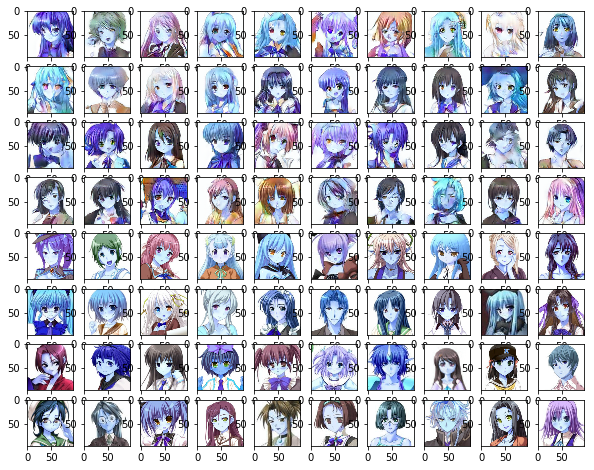

In [11]:
# Generate images from noise, using the generator network.
cnt = 0

f, a = plt.subplots(8, 10, figsize=(10, 8))
for i in range(10):
    # Noise input.
    z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
    
    batch_x, batch_y = data_X.next_batch(batch_size)
    
    batch_x = batch_x + mean_rgb
    
    g = sess.run(fake_input, feed_dict={gen_input: z, lab_input: batch_y})
    
    g = g + mean_rgb
    g[g > 1.] = 1.
    g[g < 0.] = 0.
        
    for j in range(4):
        # Generate image from noise. Extend to 3 channels for matplot figure.
        cv2.imwrite('../result/{}.jpg'.format(str(cnt).zfill(3)), g[j] * 255)
        cv2.imwrite('../result/{}.jpg'.format(str(cnt + 40).zfill(3)), batch_x[j] * 255)
        tmp = np.zeros((96, 96, 3))
        
        np.flip(g[j], 2)
        a[j][i].imshow(g[j])
        np.flip(batch_x[j], 2)
        a[j + 4][i].imshow(batch_x[j])
        cnt += 1
        
        for k in range(batch_y.shape[1]):
            if batch_y[j][k] == 1:
                print (label_dict[k], end = ', ')
        print (cnt - 1)
f.show()
plt.draw()